In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision import datasets

import matplotlib.pyplot as plt
import os
from PIL import Image
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [2]:
path='/home/amirtesh/Downloads/Computers/Python/MachineLearning/Udemy Pytorch/Convolutional neural networks/Horse Zebra'

In [3]:
train_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

test_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [4]:
train_data=datasets.ImageFolder(root=os.path.join(path,'train'),transform=train_transform)
test_data=datasets.ImageFolder(root=os.path.join(path,'test'),transform=test_transform)

In [5]:
class_names=train_data.classes
class_dict=train_data.class_to_idx

class_names,class_dict

(['horse', 'zebra'], {'horse': 0, 'zebra': 1})

In [6]:
img,label=train_data[2][0],train_data[1][1]

print(f'Image tensor:\n {img} ')
print(f'Image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Image label: {label}')
print(f'Label datatype: {type(label)}')

Image tensor:
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]) 
Image shape: torch.Size([3, 224, 224])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


Original shape: torch.Size([3, 224, 224])
Image permute: torch.Size([224, 224, 3])


Text(0.5, 1.0, 'horse')

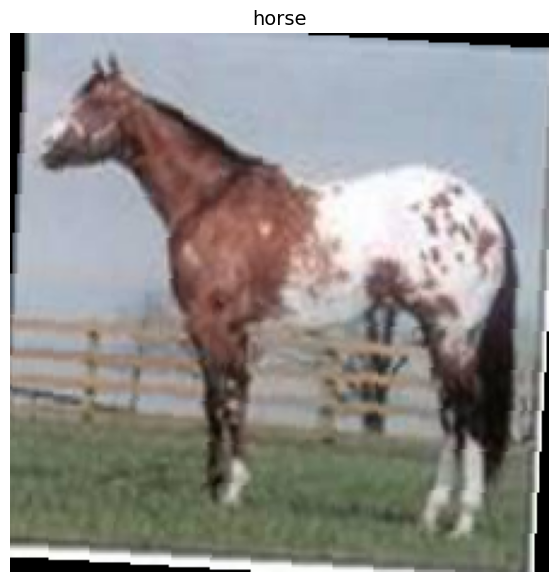

In [7]:
img_permute=img.permute(1,2,0) #changes index order
print(f'Original shape: {img.shape}') #[colour channels,height,width]
print(f'Image permute: {img_permute.shape}') #[height,width,colour channels]

plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label],fontsize=14)

In [8]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [9]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    model.eval() 
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [10]:
from tqdm import tqdm
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module,
          epochs:int):
    
    results={'train_loss':[],
             'train_acc':[],
             'test_loss':[],
             'test_acc':[]}
    
    for i in tqdm(range(epochs)):
        train_loss,train_acc=train_step(model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer)
        test_loss,test_acc=test_step(model=model,
                                     dataloader=test_dataloader,
                                     loss_fn=loss_fn)
        print(f'Epoch {i} | Train loss: {train_loss:.4f},Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f},Test acc: {test_acc:.4f}')
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    return results

In [11]:
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(3,6,3,1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(6,16,3,1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Flatten(),
            nn.Linear(54*54*16,120),
            nn.ReLU(),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,len(class_names))
        )

    def forward(self,X):
        return F.log_softmax(self.conv(X))

In [12]:
torch.manual_seed(101)
train_loader=DataLoader(dataset=train_data,batch_size=32,shuffle=True,num_workers=os.cpu_count())
test_loader=DataLoader(dataset=test_data,batch_size=32,shuffle=False,num_workers=os.cpu_count())

In [56]:
torch.manual_seed(101)
model=Model()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)


In [57]:
torch.manual_seed(42)

n=5
model1_results=train(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    epochs=n
)

 20%|██        | 1/5 [00:14<00:56, 14.15s/it]

Epoch 0 | Train loss: 0.5233,Train acc: 0.7150 | Test loss: 0.3235,Test acc: 0.8715


 40%|████      | 2/5 [00:28<00:42, 14.02s/it]

Epoch 1 | Train loss: 0.3764,Train acc: 0.8314 | Test loss: 0.3644,Test acc: 0.8403


 60%|██████    | 3/5 [00:42<00:28, 14.09s/it]

Epoch 2 | Train loss: 0.3092,Train acc: 0.8725 | Test loss: 0.2879,Test acc: 0.8854


 80%|████████  | 4/5 [00:56<00:14, 14.22s/it]

Epoch 3 | Train loss: 0.2731,Train acc: 0.8849 | Test loss: 0.2788,Test acc: 0.8819


100%|██████████| 5/5 [01:11<00:00, 14.21s/it]

Epoch 4 | Train loss: 0.2798,Train acc: 0.8832 | Test loss: 0.2765,Test acc: 0.8889


In [27]:
horse1='/home/amirtesh/Downloads/Computers/Python/MachineLearning/Udemy Pytorch/Convolutional neural networks/Horse Zebra/horse1.jpeg'
horse2='/home/amirtesh/Downloads/Computers/Python/MachineLearning/Udemy Pytorch/Convolutional neural networks/Horse Zebra/horse2.jpeg'
horse3='/home/amirtesh/Downloads/Computers/Python/MachineLearning/Udemy Pytorch/Convolutional neural networks/Horse Zebra/horse3.jpeg'

zebra1='/home/amirtesh/Downloads/Computers/Python/MachineLearning/Udemy Pytorch/Convolutional neural networks/Horse Zebra/zebra1.jpeg'
zebra2='/home/amirtesh/Downloads/Computers/Python/MachineLearning/Udemy Pytorch/Convolutional neural networks/Horse Zebra/zebra2.jpeg'
zebra3='/home/amirtesh/Downloads/Computers/Python/MachineLearning/Udemy Pytorch/Convolutional neural networks/Horse Zebra/zebra3.jpeg'

In [28]:
transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
   
])

In [40]:
def tester(model:nn.Module,
           image,
           transform:torchvision.transforms.transforms,
           class_names:list):
    
    image=torchvision.io.read_image(str(image))
    image=image.type(torch.float32)/255
    image_new=transform(image)
    model.eval()
    with torch.inference_mode():
        logit=model(image_new.unsqueeze(0))
    prob=torch.softmax(logit,dim=1)
    label=class_names[torch.argmax(prob,dim=1)]
    print(f'Predicted breed: {label}')

In [58]:
test_class=[horse1,horse2,horse2,zebra1,zebra2,zebra3]

for i in test_class:
    
    tester(model=model,
           image=i,
           transform=transform,
           class_names=class_names)

Predicted breed: horse
Predicted breed: horse
Predicted breed: horse
Predicted breed: zebra
Predicted breed: zebra
Predicted breed: zebra


In [42]:
len(test_data)

260

In [59]:
index=list(range(260))

c=0
for i in index:
    model.eval()
    with torch.no_grad():
        pred=model(test_data[i][0].view(1,3,224,224)).argmax()

    print(f'Actual: {class_names[test_data[i][1]]} | Predicted: {class_names[pred.item()]}')
    if class_names[test_data[i][1]]==class_names[pred.item()]:
        c+=1

print(f'Number of correct: {c}/{len(test_data)} | Accuracy: {c*100/len(test_data)}')

Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: horse | Predicted: zebra
Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: horse | Predicted: zebra
Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: horse | Predicted: horse
Actual: ho